In [1]:
from pathlib import Path 

import torchaudio
from speechbrain.pretrained import EncoderClassifier
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio

In [3]:
tqdm.pandas()

In [5]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


In [6]:
params = list(classifier.parameters())

In [39]:
for p in params:
    # print(p.requires_grad)
    pass

In [41]:
from speechbrain import Brain

In [43]:
# Brain??

In [23]:
params[-1].shape

torch.Size([10, 192])

In [28]:
classifier.mods['classifier']

Classifier(
  (blocks): ModuleList()
)

In [37]:
list(classifier.mods.classifier.parameters())[0].requires_grad

False

In [14]:
datadir = Path('data')
urban = pd.read_csv(datadir/'urbansound8k'/'UrbanSound8K.csv')

In [15]:
paths = [f"data/urbansound8k/fold{fold}/{fn}" for fold, fn in zip(urban.fold, urban.slice_file_name)]
urban['filepath'] = paths

In [16]:
urban.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,data/urbansound8k/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,data/urbansound8k/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,data/urbansound8k/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,data/urbansound8k/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,data/urbansound8k/fold5/100263-2-0-137.wav


In [17]:
urban.describe(include=object)

,slice_file_name,class,filepath
count,8732,8732,8732
unique,8732,10,8732
top,100032-3-0-0.wav,dog_bark,data/urbansound8k/fold5/100032-3-0-0.wav
freq,1,1000,1


In [8]:
from functools import cache 

@cache
def getpred(filepath): return classifier.classify_file(filepath)[-1][0]

In [18]:
# preds = urban.filepath.progress_apply(getpred)

In [ ]:
np.mean([p == c for p, c in zip(urban['class'], preds)])

In [ ]:
urban['preds'] = preds

In [ ]:
urban.head()

In [ ]:
recall = urban.groupby("class").apply(lambda d: (d['class']==d.preds).mean() )

In [ ]:
precision = urban.groupby("preds").apply(lambda d: (d['class']==d.preds).mean() )

In [ ]:
pd.DataFrame(dict(precision=precision, recall=recall) )

In [ ]:
accuracy = (urban['preds']==urban['class']).mean()
accuracy

## fine tuning 

In [19]:
sample = urban.filepath.sample().iloc[0]; sample

'data/urbansound8k/fold3/49485-9-0-24.wav'

In [20]:
display.Audio(sample, autoplay=True)

In [47]:
# Compute embeddings
signal, fs = torchaudio.load(sample)

In [48]:
signal.shape

torch.Size([2, 15876])

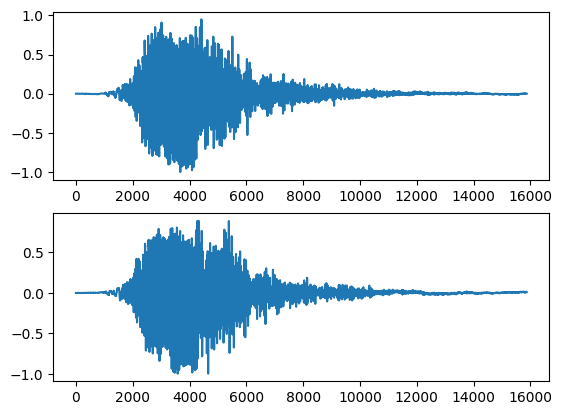

In [49]:
fig, ax = plt.subplots(2,1)
for i in range(signal.shape[0]):
    ax[i].plot(signal[i]);

In [50]:
embeddings = classifier.encode_batch(signal)

In [51]:
embeddings.shape

torch.Size([2, 1, 192])

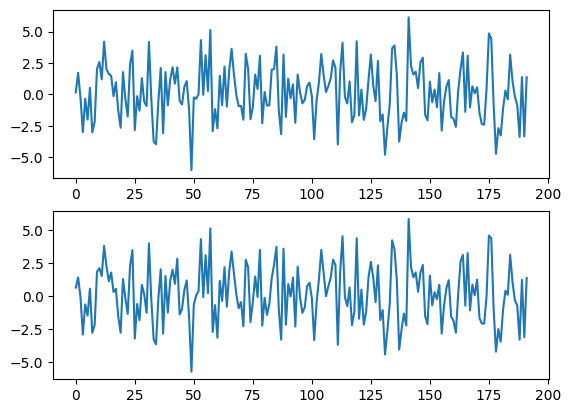

In [52]:
# plt.plot(embeddings[0].reshape(-1))

fig, ax = plt.subplots(2,1)
for i in range(embeddings.shape[0]):
    ax[i].plot(embeddings[i].reshape(-1));

In [53]:
mods = list(classifier.modules())

In [54]:
len(mods)

230

In [138]:
# Classification
prediction = classifier.classify_batch(signal)

In [139]:
prediction

(tensor([[ 0.0254, -0.1561,  0.1966, -0.1216, -0.1118,  0.4165, -0.0195, -0.2398,
           0.7003, -0.2539],
         [ 0.2123, -0.2506,  0.1862, -0.0711, -0.1345,  0.4361,  0.1215, -0.3615,
           0.5718, -0.2507]]),
 tensor([0.7003, 0.5718]),
 tensor([8, 8]),
 ['drilling', 'drilling'])

In [18]:
classifier.forward??

Signature: classifier.forward(wavs, wav_lens=None)
Source:   
    def forward(self, wavs, wav_lens=None):
        """Runs the classification"""
        return self.classify_batch(wavs, wav_lens)
File:      /usr/local/lib/python3.10/site-packages/speechbrain/pretrained/interfaces.py
Type:      method

In [17]:
type(classifier).__subclasses__()[0]

speechbrain.pretrained.interfaces.SpeakerRecognition

In [ ]:
classifier.state_dict

In [ ]:
import torch 
torch.load_state_dict(classifier.state_dict)

In [ ]:
classifier.forward()